# Introduction

This report presents the modeling of heat transfer in a copper beam using the finite difference method and boundary conditions applied at 10 C° from the left end and 50 C° from the right end. Heat transfer is a fundamental phenomenon encountered in various engineering applications, and understanding the temperature distribution in solid structures is crucial for designing efficient thermal systems.

The heat equation is a partial differential equation that describes how temperature changes over time in a given domain. In one dimension, the heat equation can be expressed as:

$$
    \kappa \frac{\partial^2{u}}{\partial{x}^2} = \frac{\partial{u}}{\partial{t}}
$$

where u(x, t) represents the temperature distribution along the beam at position x and time t, and α is the thermal diffusivity of the material.

In [37]:
using Plots
using SparseArrays
using LinearAlgebra
using BenchmarkTools

# 1.Create the source function

In this part, I model a single force acting on the beam. To do this, I will create a function that takes the form of a Gaussian function with a maximum value A representing the magnitude of the force, a width represented by the parameter σ, and located at position X0 on the beam.


$$ f(x) = A\exp{(-\frac{(x-x_0)^2}{\sigma^2})} $$

For the heat equation, this force is actually a heat peak of magnitude A, width σ and located at position X0 on the beam. In this example, the heat peak is located 60 cm along the beam, with a narrow width.

In [2]:
function source_function(x)
    X0 = 60.0
    σ = 0.8
    A = 1.
    return  A .* exp.(.-((x .- X0).^2)./σ^2)
    #return 0. .* x
end

source_function (generic function with 1 method)

In [3]:
function source(N)
#Parameter
    l = 80.
    dx = l/N
#Mesh
    X_vect = Vector(0:dx:l)
# Function source
    f = source_function(X_vect)
    return f
end

source (generic function with 1 method)

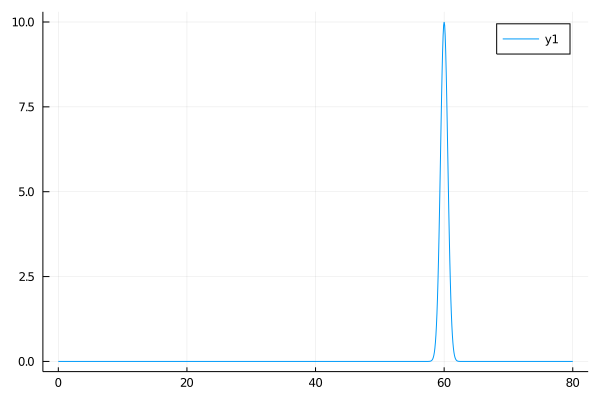

In [6]:
N = 1000
l = 80.
dx = l/N
plot(Vector(0:dx:l),source(N))

# 2.Create the inital function 

In [9]:
function init_function(x)
    A = 100.
    l = 80
    return A .* sin.((pi / l ) .* x)
end

init_function (generic function with 1 method)

In [10]:
function init(N)
    #Parameter
        l = 80.
        dx = l/N
    #Mesh
        X_vect = Vector(0:dx:l)
    # Function source
        f = init_function(X_vect)
        return f
    end

init (generic function with 1 method)

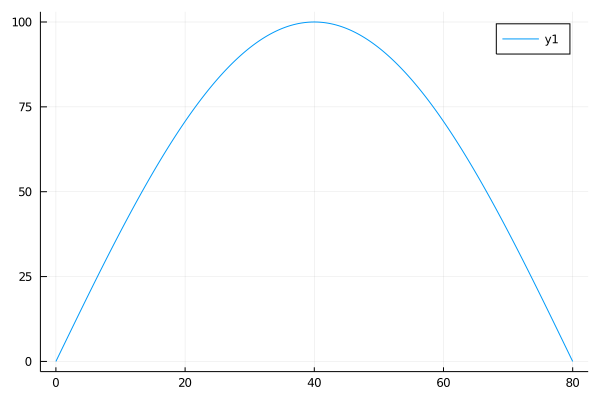

In [11]:
plot(Vector(0:dx:l),init(N))

# 3.Create the Implicit scheme to solve the Heat equation 

The 1D time dependent heat equation is a mathematical model used to describe the distribution of heat in a one-dimensional medium over time.
$$\frac{\partial^2{u}}{\partial{x}^2} = \frac{\partial{u}}{\partial{t}} $$
Where u represents the temperature distribution along the x-axis. To solve this equation numerically, we discretize the domain into small intervals dx and approximate the second derivative using finite differences.
$$
     dt \times f^{N+1}_i+ \frac{\kappa \times dt \times (U_{i+1}^{N+1} -2U_{i}^{N+1} + U_{i-1}^{N+1})}{dx^2} = U^{N+1}_i - U^N_i
$$
With the boudarys conditions :

$$
    U_0 = 150
$$
$$
    U_{N+1} = 0
$$
This leads to a system of linear equations $$ AU^{N+1} = U^N + dt F^{N+1} $$, where A is a tridiagonal matrix that represents the coefficients of the finite difference scheme, x is the vector containing the unknown temperature values at each discretized point. 
$$
A =  \begin{bmatrix}
1 & 0 & 0 & \dots & 0 \\
-\alpha & 1 + 2 \alpha & -\alpha & \dots & 0 \\
0 & -\alpha & 1 + 2 \alpha & \ddots & 0 \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
0  & \ddots & \ddots& - \alpha & 1 + 2 \alpha \\
0  & \dots & \dots & 0 & 1 \\
\end{bmatrix}
$$

With : $$\alpha = \frac{\kappa \times dt}{dx^2} $$

The vector U^N is is containing the known boundary conditionsso for this example the vector will be : 
$$
    \mathbf{U^N} = \begin{bmatrix} 150 \\ U_2 \\ U_3 \\ \vdots \\ U_N \\ U_{N+1}\end{bmatrix}^N
$$

The heat source must be added to the linear system to get the real case. 

$$
    \mathbf{S} = dt \times \begin{bmatrix} f(0) \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ f(L)\end{bmatrix}^{N+1}
$$



# A) Witout source 

In [12]:
function matrix(n) 

#Parameter for copper
    d= 8.92 #density 
    sh= 0.092 #specific_heat
    tc= 0.95 #thermal_conductivity
    l= 80.0 #length
    c = ( tc / (sh * d))^(1/2)
    dx = l/ n 
    dt = 1
    α = dt * c^2 /dx^2 

#Build the matrix 
    A = spdiagm(-1 =>  -(α )* ones(n), 0 => ((2 * α + 1) ) * ones(n+1), 1 => - ( α ) * ones(n)) 
    A[1,1] = 1
    A[1,2] = 0
    A[n+1,n+1] = 1 
    A[n+1,n] = 0
    return A
end

matrix (generic function with 1 method)

In [21]:
function heat_implicit(N) 
    
#Parameters 
    l = 80.
    dx = l/N
    tmax = 1000
    dt = 1
    time_iteration = Int(tmax/dt)
    
#Boudarys and initialization
    U = zeros(N+1, time_iteration + 1)
    U[:,1] .= init(N)
    U[1,:] .= 150
    U[end,:] .= 0
    A = matrix(N)
    
#Solving the linear problem
    for t in 1:time_iteration
        U[:,t+1] = A \ U[:,t] 
    end    

    return U

    
end

heat_implicit (generic function with 1 method)

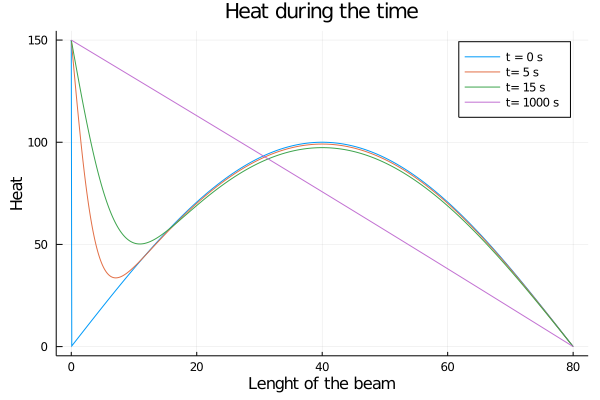

In [22]:
    title = "Heat during the time"
    X = Vector(0:dx:l)
    U = heat_implicit(N)
    plot(X, U[:,1], label = "t = 0 s", xlabel = "Lenght of the beam", ylabel = "Heat", title = title)
    plot!(X, U[:,6], label = "t= 5 s")
    plot!(X, U[:,16], label = "t= 15 s")
    plot!(X, U[:,end], label = "t= 1000 s")
        

In [41]:
@btime heat_implicit(N)

  593.979 ms (73980 allocations: 1.07 GiB)


1001×1001 Array{Float64,2}:
 150.0       150.0           …  150.0           150.0
   0.314159  139.567            150.023         150.023
   0.628314  129.905            150.046         150.047
   0.942464  120.957            150.069         150.07
   1.2566    112.672            150.093         150.093
   1.57073   105.004         …  150.116         150.116
   1.88484    97.907            150.139         150.14
   2.19894    91.3411           150.162         150.163
   2.51301    85.2681           150.185         150.186
   2.82706    79.6526           150.208         150.209
   3.14108    74.4619        …  150.231         150.233
   3.45506    69.6654           150.255         150.256
   3.76902    65.2349           150.278         150.279
   ⋮                         ⋱                    ⋮
   3.45506     3.44891            8.94392         8.94533
   3.14108     3.13548       …    8.13081         8.13209
   2.82706     2.82202            7.31771         7.31886
   2.51301     2.50853

# B) With Source 

In [34]:
function heat_implicit_source(N) 
    
#Parameters 
    l = 80.
    dx = l/N
    tmax = 1000
    dt = 1
    time_iteration = Int(tmax/dt)
    
#Boudarys and initialization
    U = zeros(N+1, time_iteration + 1)
    U[:,1] .= init(N)
    U[1,:] .= 150
    U[end,:] .= 0
    S = source(N) 
    A = matrix(N) 

#Solving the linear problem
    for t in 1:time_iteration
        U[:,t+1] = A \ (U[:,t] +  dt *S)
    end    
   return U
    
end 

heat_implicit_source (generic function with 1 method)

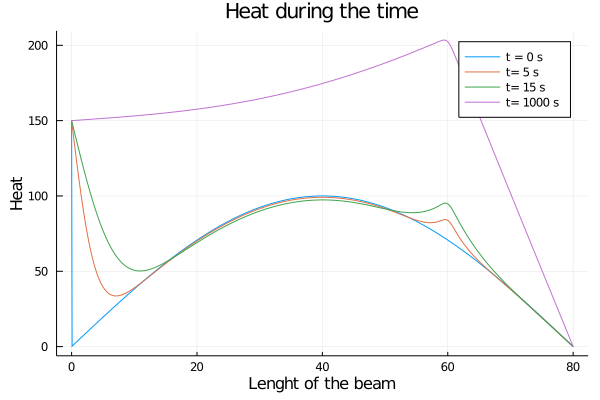

In [35]:
    title = "Heat during the time"
    X = Vector(0:dx:l)
    U = heat_implicit_source(N)
    plot(X, U[:,1], label = "t = 0 s", xlabel = "Lenght of the beam", ylabel = "Heat", title = title)
    plot!(X, U[:,6], label = "t= 5 s")
    plot!(X, U[:,16], label = "t= 15 s")
    plot!(X, U[:,end], label = "t= 1000 s")

# 4.Create the explicit scheme to solve the heat equation 

The 1D time dependent heat equation is a mathematical model used to describe the distribution of heat in a one-dimensional medium over time.
$$\frac{\partial^2{u}}{\partial{x}^2} = \frac{\partial{u}}{\partial{t}} $$
Where u represents the temperature distribution along the x-axis. To solve this equation numerically, we discretize the domain into small intervals dx and approximate the second derivative using finite differences.
$$
     dt \times f^{N}_i+ \frac{\kappa \times dt \times (U_{i+1}^{N} -2U_{i}^{N} + U_{i-1}^{N})}{dx^2} = U^{N+1}_i - U^N_i
$$
With the boudarys conditions :

$$
    U_0 = 150
$$
$$
    U_{N+1} = 0
$$

This time, I will use a iterative method that can be explained by the system : 

$$
        dt f^{N}_i+  \alpha U_{i+1}^{N} + (1-2\alpha) U_{i}^{N} + \alpha U^{N}_{i-1} = U^{N+1}_i 
$$

With $$ \alpha = \frac{\kappa \times dt}{dx^2}$$


# A) Without source 

In [48]:
function heat_explicit(N,tmax) #Iterative method 
    #Parameter for copper
    d= 8.92 #density 
    sh= 0.092 #specific_heat
    tc= 0.95 #thermal_conductivity
    l= 80.0 #length
    c = ( tc / (sh * d))^(1/2)
    dx = l/ N  
   # tmax = 60
    dt = 0.001
    α = dt * c^2 /dx^2 
    
    #Init vector  
        u = init(N)
        
    #Boundarys 
        u[1] = 150.
        u[N+1] = 0.0
      
    #Solve the system
        Unp1 = copy(u)
        for j in 1:dt: Int(tmax)
            for i in 2:N
                Unp1[i] = α * (u[i+1] - 2 * u[i] + u[i-1]) + u[i]
            end 
            u = Unp1
        end 
    
        return u
end

heat_explicit (generic function with 2 methods)

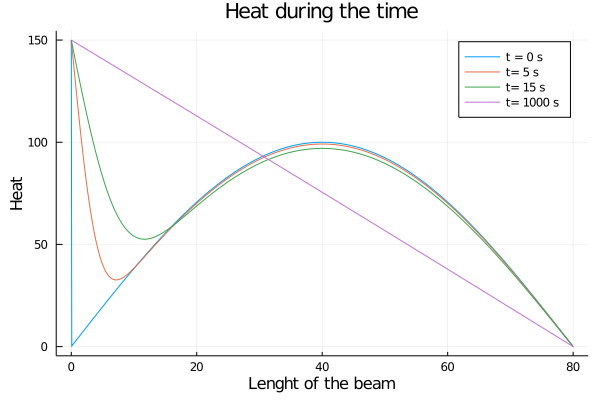

In [45]:
    plot(X, heat_explicit(N,0), label = "t = 0 s", xlabel = "Lenght of the beam", ylabel = "Heat", title = title)
    plot!(X, heat_explicit(N,5), label = "t= 5 s")
    plot!(X, heat_explicit(N,15), label = "t= 15 s")
    plot!(X, heat_explicit(N,1000), label = "t= 1000 s")

In [43]:
@btime heat_explicit(N,1000)

  4.150 s (3 allocations: 24.00 KiB)


1001-element Array{Float64,1}:
 150.0
 149.8515748214048
 149.70314962562563
 149.55472439858693
 149.40629912621333
 149.25787379442968
 149.10944838916132
 148.96102289633382
 148.81259730187347
 148.6641715917071
 148.51574575176215
 148.3673197679669
 148.21889362625046
   ⋮
   1.6683875800600603
   1.516716590634041
   1.3650454255886244
   1.2133741028761627
   1.0617026404510181
   0.9100310562693289
   0.7583593682887734
   0.606687594468336
   0.45501575276807177
   0.30334386114887196
   0.15167193757222863
   0.0

In [46]:
function heat_explicit(N,tmax) #Iterative method 
#Parameter for copper
    d= 8.92 #density 
    sh= 0.092 #specific_heat
    tc= 0.95 #thermal_conductivity
    l= 80.0 #length
    c = ( tc / (sh * d))^(1/2)
    dx = l/ N  
    dt = 0.001
    α = dt * c^2 /dx^2 
    
#Init vector  
    u = init(N)

#Boundarys 
    u[1] = 150.
    u[N+1] = 0.0
    f = source(N)

#Solve the system
    Unp1 = copy(u)
    for j in 1:dt: Int(tmax)
        for i in 2:N
            Unp1[i] = α * (u[i+1] - 2 * u[i] + u[i-1]) + u[i] + dt * f[i]
        end 
        u = Unp1
    end 

    return u 
end

heat_explicit (generic function with 2 methods)

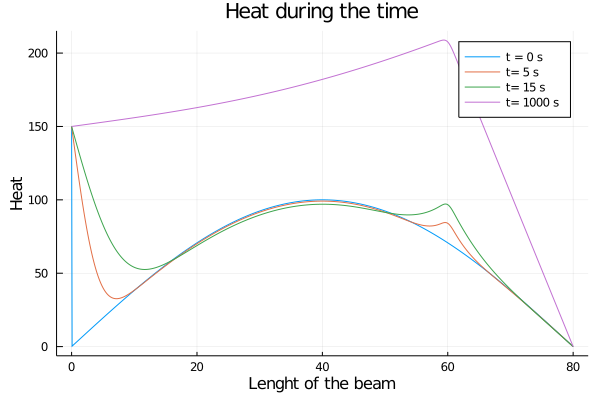

In [47]:
    plot(X, heat_explicit(N,0), label = "t = 0 s", xlabel = "Lenght of the beam", ylabel = "Heat", title = title)
    plot!(X, heat_explicit(N,5), label = "t= 5 s")
    plot!(X, heat_explicit(N,15), label = "t= 15 s")
    plot!(X, heat_explicit(N,1000), label = "t= 1000 s")